In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook Nasa_turbo_PM_updated_new.ipynb to script
[NbConvertApp] Writing 13311 bytes to Nasa_turbo_PM_updated_new.py


matplotlib==3.0.2
numpy==1.18.5
autofeat==1.1.3
Keras==2.4.3
xgboost==1.2.1
tensorflow==2.3.1
seaborn==0.9.0
pandas==0.25.3
scikit_learn==0.23.2


INFO: Successfully output requirements


In [1]:
## $xpr_param_component_name = data_fetch
## $xpr_param_component_type = pipeline_job

In [2]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [3]:
## $xpr_param_component_name = data_prep
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning"]

In [4]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [5]:
#path = "/data/turbofan"
path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [6]:
def data_extraction(file):
    import pandas
    df = pandas.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [7]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pandas.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [8]:
## $xpr_param_component_name = data_transformation
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning"]

In [9]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [10]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [11]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [12]:
## $xpr_param_component_name = feature_engineering
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning","feature_engineering"]

In [13]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [14]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = matplotlib.pyplot.subplots(figsize=(10,10))
    axes = seaborn.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 1, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    X_train_transformed = X_train_transformed.to_numpy()
    X_test_transformed = X_test_transformed.to_numpy()
    return X_train_transformed, X_test_transformed, y_train, y_test

In [15]:
## $xpr_param_component_name = training
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning","feature_engineering"]

In [16]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [17]:
#path = "/data/turbofan"
path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [18]:
def data_extraction(file):
    import pandas
    df = pandas.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [19]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pandas.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [20]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [21]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [22]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = matplotlib.pyplot.subplots(figsize=(10,10))
    axes = seaborn.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 1, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    X_train_transformed = X_train_transformed.to_numpy()
    X_test_transformed = X_test_transformed.to_numpy()
    return X_train_transformed, X_test_transformed, y_train, y_test

In [23]:
def LSTM_model(X_train_normalized, y_train, X_test_normalized, y_test):
    # Defining a 2-layer stacked LSTM
    X_train_lstm = numpy.reshape(X_train_normalized,(X_train_normalized.shape[0],1,-1)) 
    print("Shape of X_train = "+str(X_train_lstm.shape))
    X_test_lstm = numpy.reshape(X_test_normalized,(X_test_normalized.shape[0],1,-1))
    print("Shape of X_train = "+str(X_test_lstm.shape))
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1]), return_sequences = True))
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=20, validation_split=0.20)
    y_test_pred_lstm = model.predict(X_test_lstm)
    R2_test_lstm = r2_score(y_test_pred_lstm, y_test)
    #print("\nR2 Score on the test dataset with LSTM = " + str(R2_test_lstm))
    #model.save("Model/lstm_model")
    #reconstructed_model = keras.models.load_model("Model/lstm_model")
    return model, R2_test_lstm

In [24]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [25]:
# Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)
df_cleaned

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38   

            s4     s5  ...      s13      s14     s15   s16  s17   s18    s19  \
0      1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1      1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2      1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3      1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4      1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
...        ...    ...  ...      ...      ...     ...   ...  ...   ...    ...   
20626  1428.63  14.62  ...  2388.26  8137.60  8.4956  0.03  397  2388  100.0   
20627  1433.58  14.62  ...  2388.22  8136.50  8.5139  0.03  395  2388  100.0   
20628  1428.18  14.62  ...  2388.24  8141.05  8.5646  0.03  398  2388  100.0   
20629  1426.53  14.62  ...  2388.23  8139.29  8.5389  0.03  395  2388  100.0   
20630  1432.14  14.62  ...  2388.26  8137.33  8.5036  0.03  396  2388  100.0   

         s20      s21  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
20626  38.49  22.9735    4  
20627  38.30  23.1594    3  
20628  38.44  22.9333    2  
20629  38.29  23.0640    1  
20630  38.37  23.0522    0  

[20631 rows x 27 columns]

[AutoFeat] The 1 step feature engineering process could generate up to 168 features.
[AutoFeat] With 16504 data points this new feature matrix would use about 0.01 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 74 transformed features from 24 original features - done.
[feateng] Generated altogether 74 new features in 1 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 74 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 16 features after 1 feature selection runs
[featsel] 16 features after correlation filtering
[featsel] 15 features after noise filtering
[AutoFeat] Computing 3 new features.
[AutoFeat]     3/    3 new features ...done.
[AutoFeat] Final dataframe with 27 feature columns (3 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
124.82690407986628
-12.416383 * x013
-10.428244 *

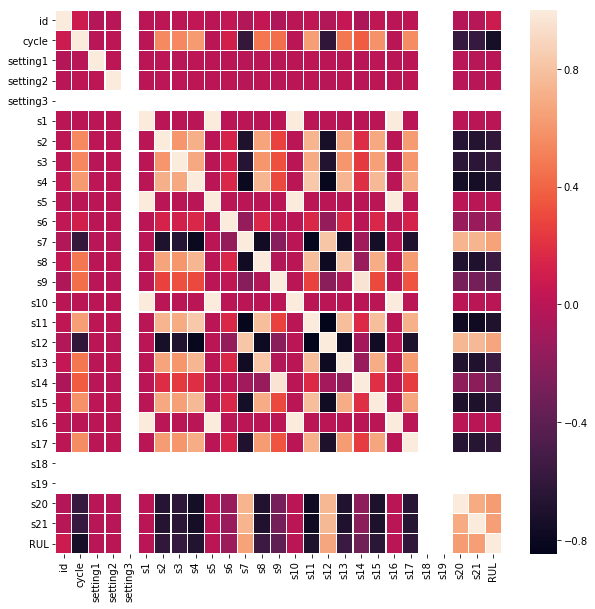

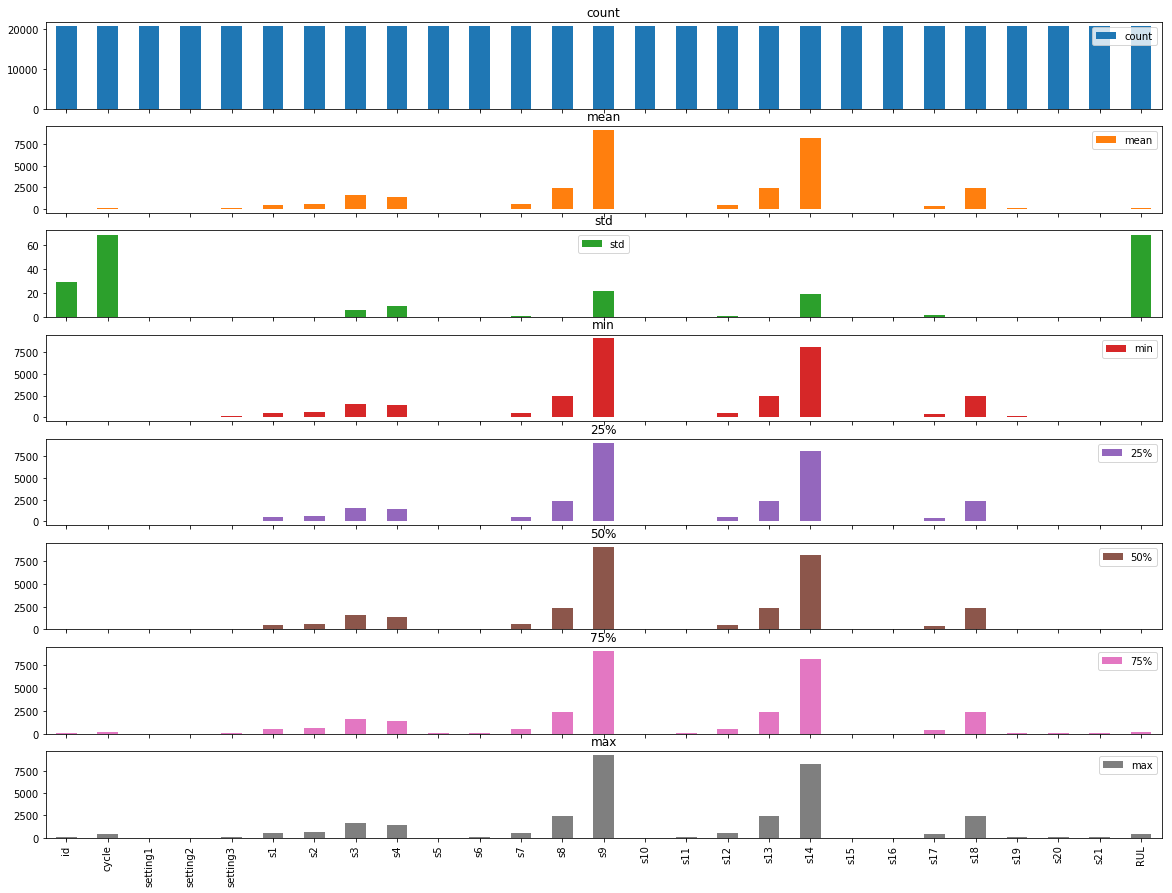

In [26]:
# Train-test split, normalization and feature engineering
X_train_transformed, X_test_transformed, y_train, y_test = feature_engineering(df_cleaned)

In [27]:
# # Fitting Random Forest model
# print("1. Using Random Forest:\n")
# model_ML, R2_test_ML = ML_model(X_train_transformed, y_train, X_test_transformed, y_test)

# Fitting LSTM model
print("2. Using LSTM:\n")
model_lstm, R2_test_lstm = LSTM_model(X_train_transformed, y_train, X_test_transformed, y_test)

2. Using LSTM:

Shape of X_train = (16504, 1, 27)
Shape of X_train = (4127, 1, 27)
Epoch 1/20
413/413 [==============================] - 2s 4ms/step - loss: 4792.8818 - val_loss: 1779.5199
Epoch 2/20
413/413 [==============================] - 1s 3ms/step - loss: 1776.4894 - val_loss: 1689.3800
Epoch 3/20
413/413 [==============================] - 1s 3ms/step - loss: 1742.7867 - val_loss: 1677.1495
Epoch 4/20
413/413 [==============================] - 1s 3ms/step - loss: 1731.0540 - val_loss: 1668.2677
Epoch 5/20
413/413 [==============================] - 1s 3ms/step - loss: 1726.3074 - val_loss: 1666.2552
Epoch 6/20
413/413 [==============================] - 1s 3ms/step - loss: 1723.1561 - val_loss: 1661.7756
Epoch 7/20
413/413 [==============================] - 1s 3ms/step - loss: 1715.6719 - val_loss: 1666.0084
Epoch 8/20
413/413 [==============================] - 1s 3ms/step - loss: 1716.2155 - val_loss: 1653.1707
Epoch 9/20
413/413 [==============================] - 1s 3ms/step - l

In [28]:
if not os.path.exists("/output"):
    os.makedirs("/output")

In [29]:
model_lstm.save(os.path.join("/output", 'saved_model.h5'))